In [1]:
import time
a = time.time()

In [2]:
import os
import json 
import subprocess
import importlib
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

/home/datacomp/miniconda3/envs/bitinfo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [31]:
path_to_data = '../data/netcdf/ecmwf_hs3g_20181101_sst.nc'  # change this
ds = xr.open_dataset(path_to_data)

In [32]:
ds = ds.sel({'longitude': ds.longitude[::],
                   'latitude': ds.latitude[:12000]
                  })

In [33]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 24000, latitude: 12000, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.015 0.03 0.045 ... 360.0 360.0 360.0
  * latitude   (latitude) float32 90.0 89.99 89.97 ... -89.96 -89.97 -89.99
  * time       (time) datetime64[ns] 2018-11-01T18:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-27 08:29:25 GMT by grib_to_netcdf-2.30.2: grib_to_n...

In [34]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude",
                                     # implementation="python"
                                    )

Processing var: sst for dim: latitude: 100%|██████████████████████████████████████████| 1/1 [01:20<00:00, 80.01s/it]


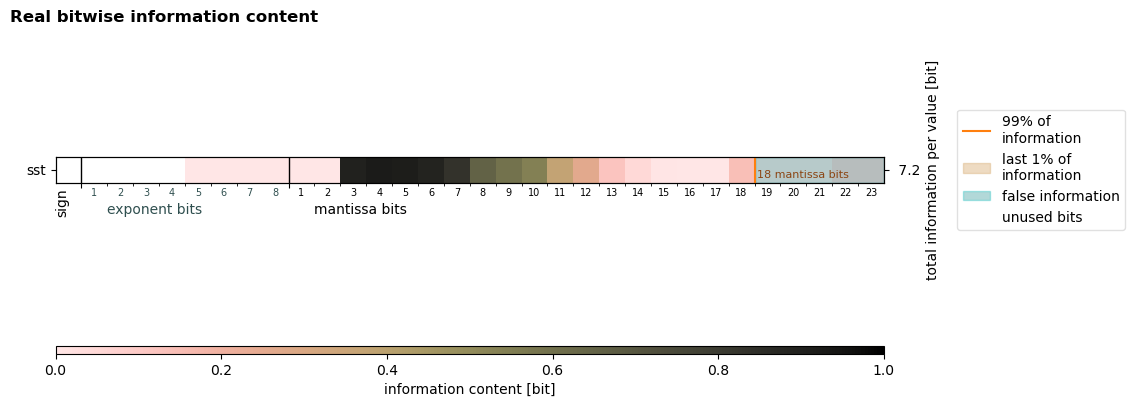

In [35]:
fig = xb.plot_bitinformation(info_per_bit)

In [36]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)
keepbits

<xarray.Dataset>
Dimensions:   (inflevel: 1)
Coordinates:
    dim       <U8 'latitude'
  * inflevel  (inflevel) float64 0.99
Data variables:
    sst       (inflevel) int64 18

In [37]:
# apply bitrounding max 15 kb
ds_bitrounded_99p = xb.xr_bitround(ds, keepbits)
# apply bitrounding min = 10 kb
ds_bitrounded_10 = xb.xr_bitround(ds, 10)

In [38]:
ds_bitrounded_10.to_compressed_netcdf("bitrounded_compressed_10.nc")
ds_bitrounded_99p.to_compressed_netcdf("bitrounded_compressed_99p.nc")

In [13]:
# ds.to_compressed_netcdf("compressed.nc")

In [39]:
ds.to_netcdf("original.nc")

---

In [40]:
at_least_zero = lambda x: [max(y, 0) for y in x]

chunk_long, chunk_lat = [800, 400] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        var_kp = list(temp_keepbits.keys())[0]
        # cope with negative keepbits
        temp_keepbits[var_kp].data = at_least_zero(temp_keepbits[var_kp].data)
        dss_kbits.append(temp_keepbits)
        
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)

        if i == 0 and j == 0 : 
            MERGED_ds_bitr = temp_ds_bitrounded
        else:
            MERGED_ds_bitr = xr.merge([MERGED_ds_bitr, temp_ds_bitrounded])

Processing var: sst for dim: latitude: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


In [41]:
MERGED_ds_bitr.to_compressed_netcdf("bitrounded_compressed_merged_chunks.nc")

---

In [42]:
variables = list(ds.keys())
variables

['sst']

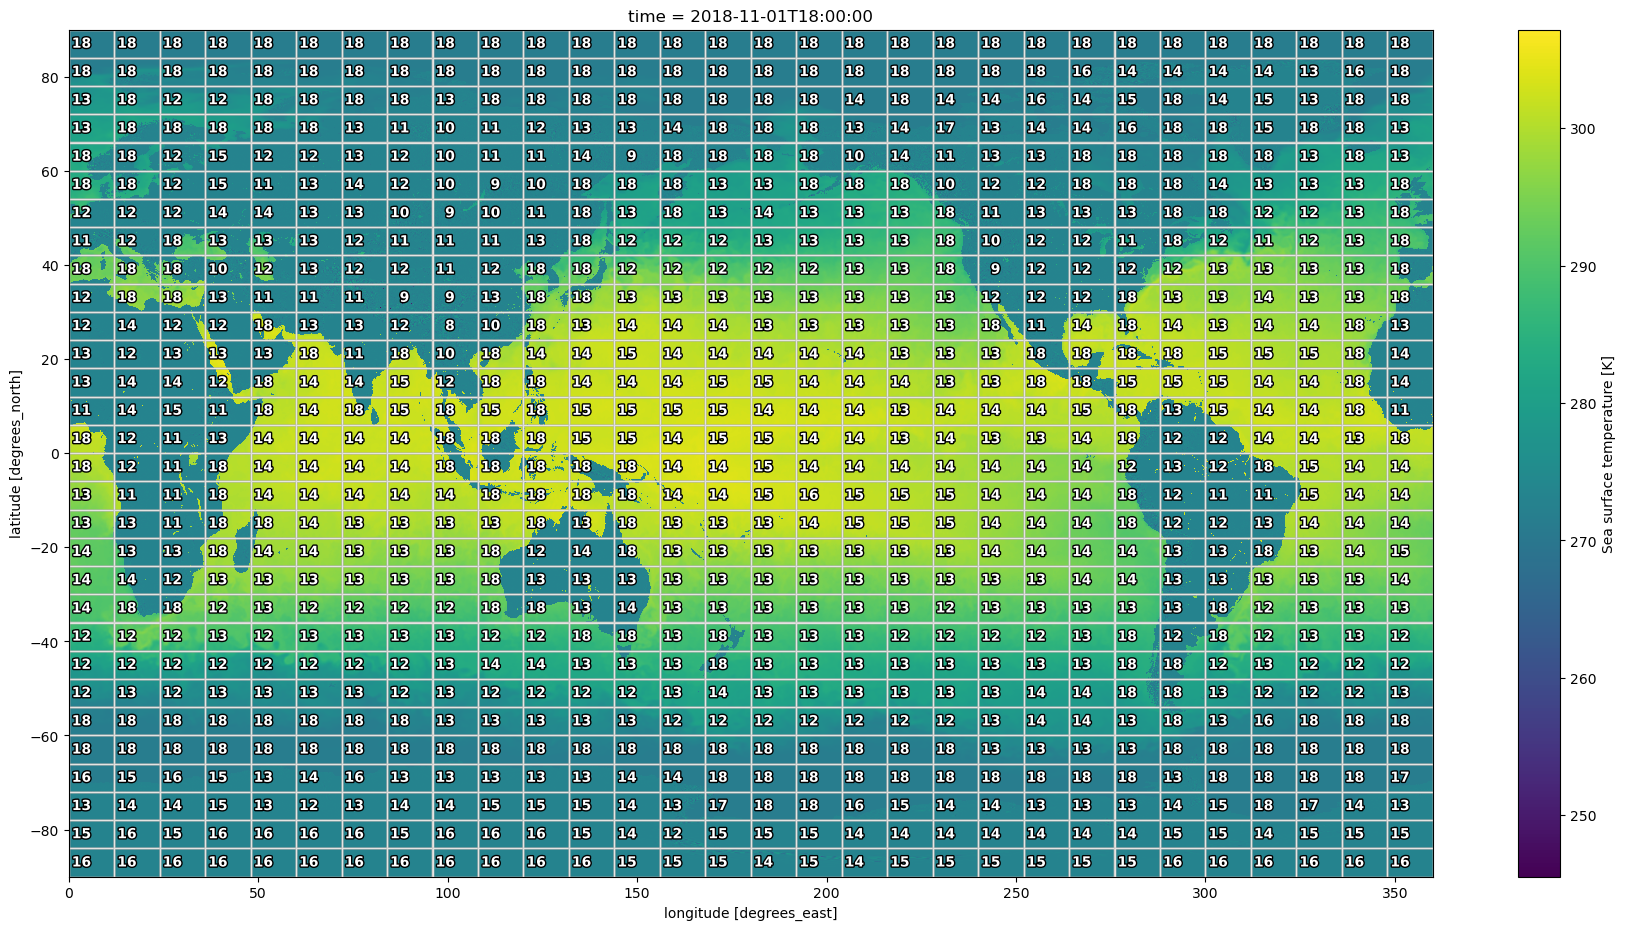

In [43]:
for v in variables:
    fig, ax = plt.subplots(figsize=(22, 11))
        
    ds[v].plot(ax=ax)

    for i in range(len(dss_bitrounded)):
        x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
        y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
        w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
        h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[i][v]):2}
            """,
            (cx, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')]
        )

    fig.show()

In [44]:
data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
variables = list(ds.keys())

df = pd.DataFrame(data=data,
                  columns=variables)
df.head()              

/tmp/ipykernel_25139/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_25139/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_25139/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(d

,sst
0,18
1,18
2,13
3,13
4,18


In [45]:
df.describe()

,sst
count,900.000000
mean,14.614444
std,2.429246
min,8.000000
25%,13.000000
50%,14.000000
75%,18.000000
max,18.000000


---

In [46]:
!du -hs *.nc

26M	bitrounded_compressed_10.nc
204M	bitrounded_compressed_99p.nc
113M	bitrounded_compressed_merged_chunks.nc
1.1G	original.nc


In [47]:
!rm *.nc

In [48]:
du_output = """26M	bitrounded_compressed_10.nc
204M	bitrounded_compressed_99p.nc
113M	bitrounded_compressed_merged_chunks.nc
1.1G	original.nc
"""
du_output

'26M\tbitrounded_compressed_10.nc\n204M\tbitrounded_compressed_99p.nc\n113M\tbitrounded_compressed_merged_chunks.nc\n1.1G\toriginal.nc\n'

In [49]:
def convert_to_bytes(size_str):
    multipliers = {'K': 1e3, 'M': 1e6, 'G': 1e9, 'T': 1e12}  # Define multipliers for different units
    unit = size_str[-1]
    size = float(size_str[:-1])
    return size * multipliers[unit]

dict_sizes = {}

for line in du_output.splitlines():
    size, name = line.split('\t')
    dict_sizes[name] = convert_to_bytes(size)

dict_sizes

{'bitrounded_compressed_10.nc': 26000000.0,
 'bitrounded_compressed_99p.nc': 204000000.0,
 'bitrounded_compressed_merged_chunks.nc': 113000000.0,
 'original.nc': 1100000000.0}

In [50]:
dict_sizes_ori = {}
for line in du_output.splitlines():
    size, name = line.split('\t')
    dict_sizes_ori[name] = size

dict_sizes_ori

{'bitrounded_compressed_10.nc': '26M',
 'bitrounded_compressed_99p.nc': '204M',
 'bitrounded_compressed_merged_chunks.nc': '113M',
 'original.nc': '1.1G'}

In [51]:
def sort_dict_by_values(d):
    sorted_items = sorted(d.items(), key=lambda item: item[1])
    return dict(sorted_items)

sorted_dict = sort_dict_by_values(dict_sizes)

In [52]:
sorted_dict_2 = {}
for k in sorted_dict.keys():
    sorted_dict_2[k] = dict_sizes_ori[k]    

In [53]:
sorted_dict_2

{'bitrounded_compressed_10.nc': '26M',
 'bitrounded_compressed_merged_chunks.nc': '113M',
 'bitrounded_compressed_99p.nc': '204M',
 'original.nc': '1.1G'}

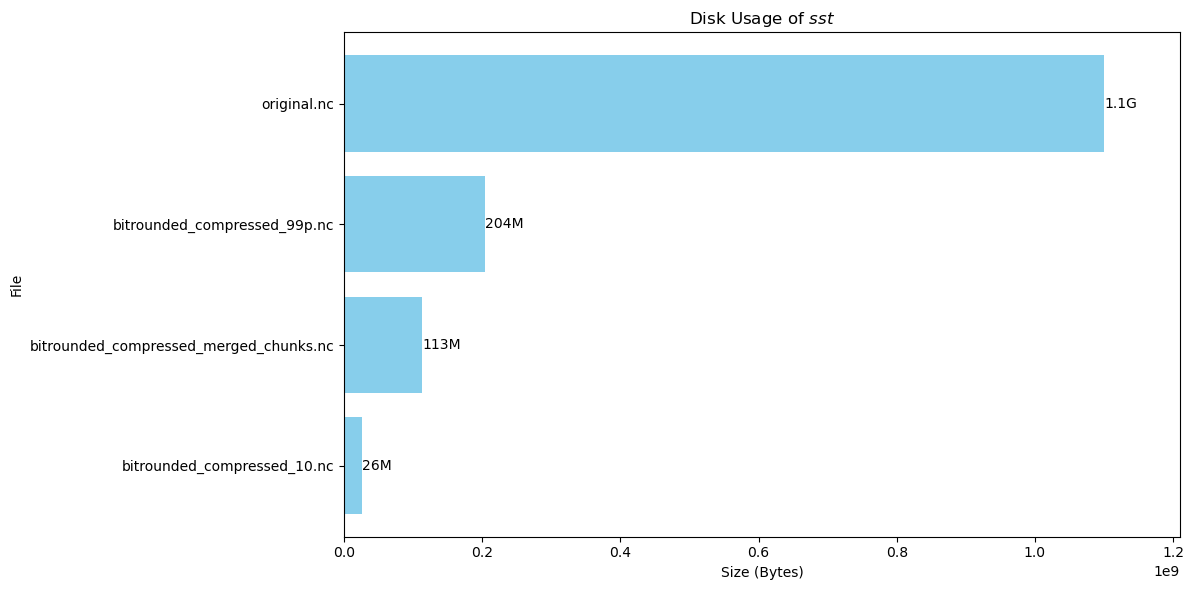

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(list(sorted_dict.keys()), list(sorted_dict.values()), color='skyblue')
ax.bar_label(bars, labels=sorted_dict_2.values())

ax.set_xlabel('Size (Bytes)')
ax.set_ylabel('File')
ax.set_title(f'Disk Usage of ${variables[0]}$')
plt.tight_layout()

ax.set_xlim(right=max(sorted_dict.values())*1.1)
plt.show()

In [55]:
b = time.time()
t = int(b - a)

def format_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    remaining_seconds = seconds % 60

    time_string = f"{hours:02}:{minutes:02}:{remaining_seconds:02}"
    return time_string

format_seconds(t)

'02:20:53'